In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageChops
import cv2
from scipy.fftpack import fft, fftshift, ifft
from skimage.transform import radon, rescale, iradon, rotate
from scipy.signal import hilbert, chirp

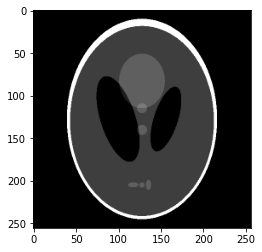

In [2]:
imagen = cv2.imread('shepp_logan.png', 0)

plt.imshow(imagen, cmap = 'Greys_r')
plt.show()

In [21]:
def mover_imagen(imagen, des_x, des_y):
    x, y = imagen.shape

    copia = imagen.copy()

    des_y *= -1

    if des_x >= 0 and des_y >= 0:
        for i in range(x):
            for j in range(y):
                copia[i][j] = imagen[i - des_y][j - des_x]
                
    elif des_x >= 0 and des_y <= 0:
        for i in range(x):
            for j in range(y):
                copia[i + des_y][j] = imagen[i][j - des_x]

    elif des_x <= 0 and des_y >= 0:
        for i in range(x):
            for j in range(y):
                copia[i][j + des_x] = imagen[i - des_y][j]
    
    else:
        for i in range(x):
            for j in range(y):
                copia[i + des_y][j + des_x] = imagen[i][j]

    return copia

In [22]:
def rotar_imagen(imagen, angulo):
    copia = Image.fromarray(imagen.astype('uint8'))

    return np.array(copia.rotate(angulo))

In [23]:
def transformar(imagen, des_x = 0, des_y = 0, angulo = 0):
    rotada = rotar_imagen(imagen, angulo)
    copia = mover_imagen(rotada, des_x, des_y)

    return copia

def invertir_transformar(imagen, des_x = 0, des_y = 0, angulo = 0):
    imagen = np.array(imagen)
    movida = mover_imagen(imagen, -des_x, -des_y)
    copia = rotar_imagen(movida, -angulo)

    return copia

In [24]:
def encontrar_maximo(imagen):
    x, y = imagen.shape
    maximo = 0

    for i in range(x):
        for j in range(y):
            if imagen[i][j] > maximo:
                maximo = imagen[i][j]

    return maximo


def invertir_intensidad(imagen):
    x, y = imagen.shape
    maximo = encontrar_maximo(imagen)
    copia = imagen.copy()

    for i in range(x):
        for j in range(y):
            copia[i][j] = maximo - imagen[i][j]
            
            if copia[i][j] < 180:
                copia[i][j] = copia[i][j] * 0.25
            else:
                copia[i][j] = copia[i][j] * 1

    return copia

In [25]:
def arreglar_esquinas(imagen):
    x, y = imagen.shape
    copia = imagen.copy()

    for i in range(x):
        for j in range(y):
            if (i - x / 2) ** 2 + (j - y / 2) ** 2 > x ** 2 / 4:
                if copia[i][j] > 200:
                    copia[i][j] = 0

    return copia

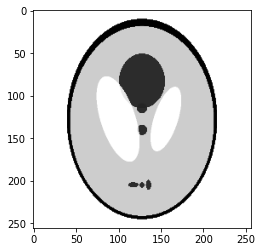

In [26]:
plt.imshow(invertir_intensidad(imagen), cmap='gray')
plt.show()

In [27]:
imagen_pet = invertir_intensidad(imagen)
imagen_ct = transformar(imagen, 9, -2, 3)

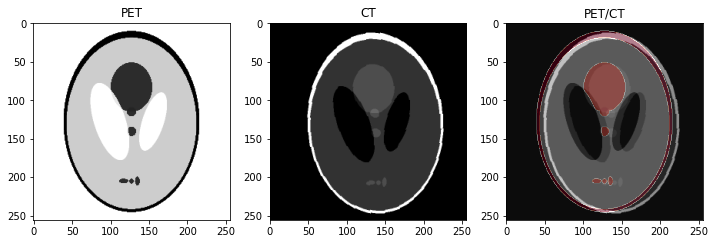

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

ax[0].imshow(imagen_pet, cmap='gray')
ax[0].set_title('PET')

ax[1].imshow(imagen_ct, cmap='gray')
ax[1].set_title('CT')

ax[2].imshow(imagen_ct, cmap='gray')
ax[2].imshow(imagen_pet, cmap='RdGy', alpha=0.5)
ax[2].set_title('PET/CT')

plt.show()

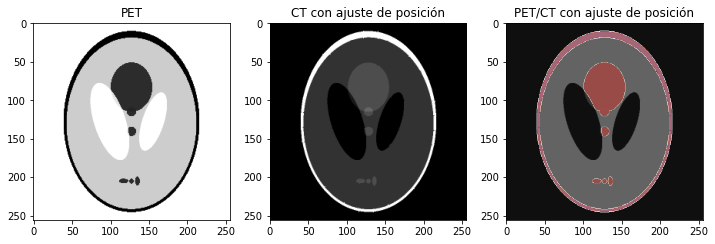

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

ax[0].imshow(imagen_pet, cmap='gray')
ax[0].set_title('PET')

ax[1].imshow(invertir_transformar(imagen_ct, 9, -2, 3), cmap='gray')
ax[1].set_title('CT con ajuste de posición')

ax[2].imshow(invertir_transformar(imagen_ct, 9, -2, 3), cmap='gray')
ax[2].imshow(imagen_pet, cmap='RdGy', alpha=0.6)
ax[2].set_title('PET/CT con ajuste de posición')

plt.show()

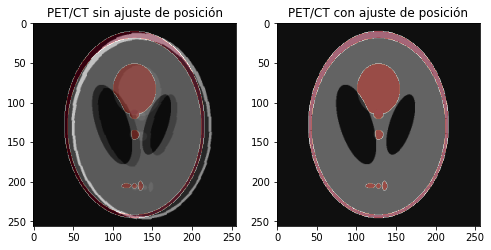

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5))

ax[0].imshow(imagen_ct, cmap='gray')
ax[0].imshow(imagen_pet, cmap='RdGy', alpha=0.5)
ax[0].set_title('PET/CT sin ajuste de posición')

ax[1].imshow(invertir_transformar(imagen_ct, 9, -2, 3), cmap='gray')
ax[1].imshow(imagen_pet, cmap='RdGy', alpha=0.6)
ax[1].set_title('PET/CT con ajuste de posición')

plt.show()

## Pregunta 3

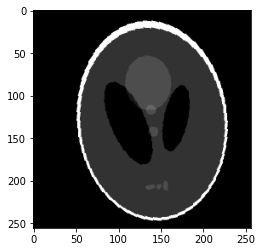

In [109]:
img_test = transformar(imagen, 12, -2, 6)
plt.imshow(img_test, cmap='gray')
plt.show()

In [89]:
theta = np.linspace(0., 360., 360, endpoint=False)
sinogram = radon(imagen, theta = theta, preserve_range = True)
sinogram_transform = radon(img_test, theta = theta, preserve_range = True)

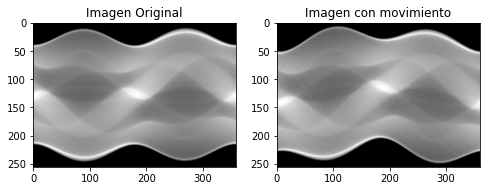

In [110]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5))

ax[0].imshow(sinogram, cmap='gray')
ax[0].set_title('Imagen Original')

ax[1].imshow(sinogram_transform, cmap='gray')
ax[1].set_title('Imagen con movimiento')

plt.show()

In [91]:
# Reconstrucción en el dominio de Fourier
# https://github.com/csheaff/filt-back-proj/blob/633687a4a81cb306a55570752b6b9e9eefaba2a6/py/filtbackproj.py

def projFilter(sino):
    """filter projections. Normally a ramp filter multiplied by a window function is used in filtered
    backprojection. The filter function here can be adjusted by a single parameter 'a' to either approximate
    a pure ramp filter (a ~ 0)  or one that is multiplied by a sinc window with increasing cutoff frequency (a ~ 1).
    Credit goes to Wakas Aqram. 
    inputs: sino - [n x m] numpy array where n is the number of projections and m is the number of angles used.
    outputs: filtSino - [n x m] filtered sinogram array"""
    
    a = 0.1;
    projLen, numAngles = sino.shape
    step = (2 * np.pi / projLen)
    w = np.arange(-np.pi, np.pi, step)
    if len(w) < projLen:
        w = np.concatenate([w, [w[-1] + step]]) #depending on image size, it might be that len(w) =  
                                              #projLen - 1. Another element is added to w in this case
    rn1 = abs(2 / a * np.sin (a * w / 2));  #approximation of ramp filter abs(w) with a funciton abs(sin(w))
    rn2 = np.sin(a * w / 2) / (a * w / 2);   #sinc window with 'a' modifying the cutoff freqs
    r = rn1 * (rn2) ** 2;              #modulation of ramp filter with sinc window
    
    filt = fftshift(r)   
    filtSino = np.zeros((projLen, numAngles))
    for i in range(numAngles):
        projfft = fft(sino[:, i])
        filtProj = projfft * filt
        filtSino[:, i] = np.real(ifft(filtProj))

    return filtSino
        
def backproject(sinogram, theta):
    """Backprojection function. 
    inputs:  sinogram - [n x m] numpy array where n is the number of projections and m the number of angles
             theta - vector of length m denoting the angles represented in the sinogram
    output: backprojArray - [n x n] backprojected 2-D numpy array"""
    x, y = sinogram.shape
    imageLen = x
    reconMatrix = np.zeros((imageLen, imageLen))
    
    x = np.arange(imageLen) - imageLen / 2 #create coordinate system centered at (x,y = 0,0)
    y = x.copy()
    X, Y = np.meshgrid(x, y)

    plt.ion()
    fig2, ax = plt.subplots()
    im = plt.imshow(reconMatrix, cmap = 'gray')
    
    numAngles = len(theta)

    theta *= np.pi / 180 #convert to radians

    for n in range(numAngles):
        Xrot = X * np.sin(theta[n]) - Y * np.cos(theta[n]) #determine rotated x-coordinate about origin in mesh grid form
        XrotCor = np.round(Xrot + imageLen / 2) #shift back to original image coordinates, round values to make indices
        XrotCor = XrotCor.astype('int')
        projMatrix = np.zeros((imageLen, imageLen))
        m0, m1 = np.where((XrotCor >= 0) & (XrotCor <= (imageLen - 1))) #after rotating, you'll inevitably have new coordinates that exceed the size of the original
        s = sinogram[:, n] #get projection
        projMatrix[m0, m1] = s[XrotCor[m0, m1]]  #backproject in-bounds data
        reconMatrix += projMatrix
        im.set_data(Image.fromarray((reconMatrix - np.min(reconMatrix)) / np.ptp(reconMatrix) * 255))
        ax.set_title('Theta = %.2f degrees' % theta[n])
        fig2.canvas.draw()
        fig2.canvas.flush_events()
         
    plt.close()
    plt.ioff()
    backprojArray = np.flipud(reconMatrix)
    return backprojArray

In [92]:
def reconstruir_fourier(sinogram):
    filtSino_transform = projFilter(sinogram)  #numpy array

    recon_transform = backproject(filtSino_transform, theta)
    recon_transform2 = np.round((recon_transform - np.min(recon_transform)) / np.ptp(recon_transform) * 255) #convert values to integers 0-255
    reconImg_transform = Image.fromarray(recon_transform2.astype('uint8'))
    img_transform = reconImg_transform.rotate(90)

    return img_transform    

In [93]:
# Reconstruction usando retroproyección filtrada

def single_filtered_back_projection_hilbert(rdn, alpha_idx):
    proj = np.imag(hilbert(rdn[:, alpha_idx]))
    proj = np.tile(proj[:, np.newaxis], (1, rdn.shape[0]))
    return rotate(proj, 90 + alpha_idx / np.asarray(rdn).shape[1] * 360)
    
def filtered_back_projection_hilbert(rdn, n_alphas= -1):
    if n_alphas <= 0:
        n_alphas = np.asarray(rdn).shape[1]
    res = np.zeros((np.asarray(rdn).shape[0], np.asarray(rdn).shape[0]))
    for i in range(n_alphas):
        res += single_filtered_back_projection_hilbert(rdn, i)

    return res / np.max(res)

In [94]:
def reconstruir_hilbert(sinogram):
    hilbert_img_transform = filtered_back_projection_hilbert(sinogram)
    img = np.round((hilbert_img_transform - np.min(hilbert_img_transform)) / np.ptp(hilbert_img_transform) * 255) #convert values to integers 0-255
    return img

In [95]:
def reconstruccion_suma(sinogram):
    img = reconstruir_fourier(sinogram) + invertir_intensidad(reconstruir_hilbert(sinogram))
    return img

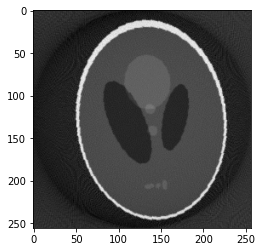

In [96]:
img_fourier = reconstruir_fourier(sinogram_transform)
plt.imshow(img_fourier, cmap = 'gray')
plt.show()

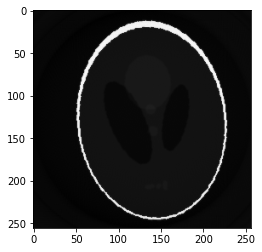

In [97]:
img_hilbert = invertir_intensidad(reconstruir_hilbert(sinogram_transform))
plt.imshow(img_hilbert, cmap = 'gray')
plt.show()

In [101]:
img_suma = img_fourier + img_hilbert

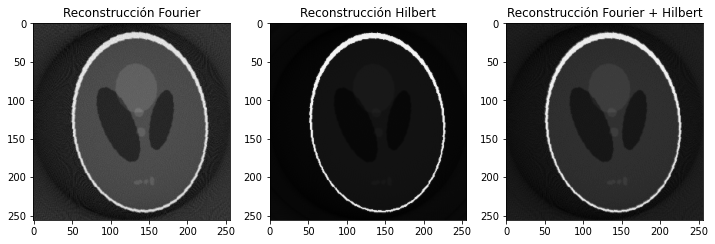

In [102]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

ax[0].imshow(img_fourier, cmap='gray')
ax[0].set_title('Reconstrucción Fourier')

ax[1].imshow(img_hilbert, cmap='gray')
ax[1].set_title('Reconstrucción Hilbert')

ax[2].imshow(img_suma, cmap='gray')
ax[2].set_title('Reconstrucción Fourier + Hilbert')

plt.show()

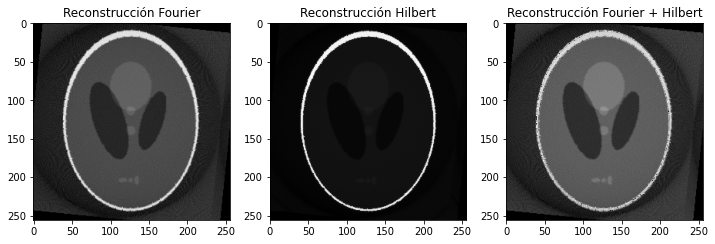

In [103]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

ax[0].imshow(invertir_transformar(img_fourier, 12, -2, 6), cmap='gray')
ax[0].set_title('Reconstrucción Fourier')

ax[1].imshow(invertir_transformar(img_hilbert, 12, -2, 6), cmap='gray')
ax[1].set_title('Reconstrucción Hilbert')

ax[2].imshow(invertir_transformar(img_suma, 12, -2, 6), cmap='gray')
ax[2].set_title('Reconstrucción Fourier + Hilbert')

plt.show()

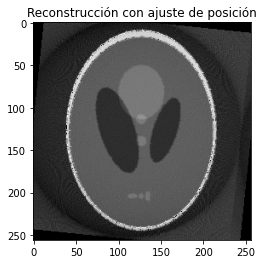

In [105]:
revert = invertir_transformar(img_suma, 12, -2, 6)
plt.imshow(revert, cmap = 'gray')
plt.title('Reconstrucción con ajuste de posición')
plt.show()

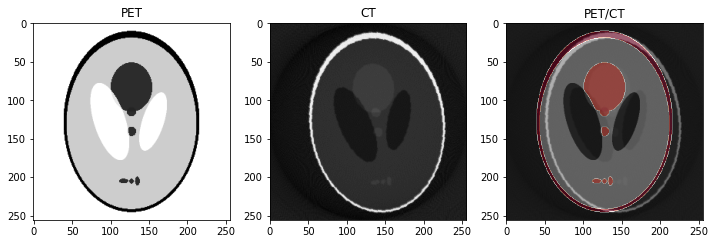

In [111]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

ax[0].imshow(imagen_pet, cmap='gray')
ax[0].set_title('PET')

ax[1].imshow(img_suma, cmap='gray')
ax[1].set_title('CT')

ax[2].imshow(img_suma, cmap='gray')
ax[2].imshow(imagen_pet, cmap='RdGy', alpha=0.6)
ax[2].set_title('PET/CT')

plt.show()

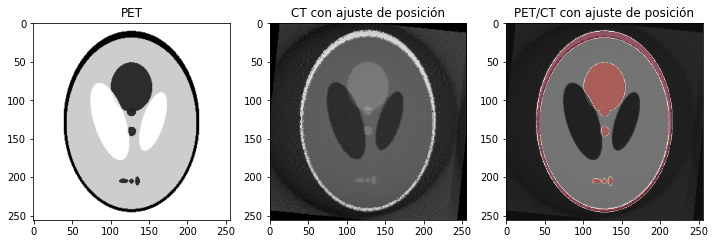

In [107]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

ax[0].imshow(imagen_pet, cmap='gray')
ax[0].set_title('PET')

ax[1].imshow(revert, cmap='gray')
ax[1].set_title('CT con ajuste de posición')

ax[2].imshow(revert, cmap='gray')
ax[2].imshow(imagen_pet, cmap='RdGy', alpha=0.6)
ax[2].set_title('PET/CT con ajuste de posición')

plt.show()

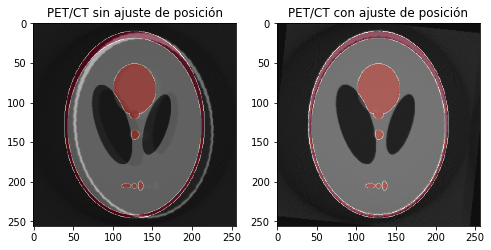

In [112]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5))

ax[0].imshow(img_suma, cmap='gray')
ax[0].imshow(imagen_pet, cmap='RdGy', alpha=0.6)
ax[0].set_title('PET/CT sin ajuste de posición')

ax[1].imshow(revert, cmap='gray')
ax[1].imshow(imagen_pet, cmap='RdGy', alpha=0.6)
ax[1].set_title('PET/CT con ajuste de posición')

plt.show()